In [75]:
!uv pip install lightgbm optuna scikit-learn pandas matplotlib seaborn IProgress jupyter ipywidgets -U -q

In [ ]:
!uv pip install ../../target/wheels/perpetual-1.0.0-cp313-cp313-win_amd64.whl

Using Python 3.13.7 environment at: C:\work\perpetual\rust_project\forust-main-perp-oss\.venv
Audited 1 package in 5ms


In [77]:
import math
from functools import partial
from time import process_time, time

import numpy as np
import optuna
import pandas as pd
from lightgbm import LGBMClassifier
from perpetual import PerpetualBooster
from sklearn.metrics import log_loss
from sklearn.model_selection import KFold, cross_validate, train_test_split
from sklearn.utils import resample

In [78]:
pd.set_option("display.max_columns", None)

In [79]:
from sklearn.datasets import fetch_openml

data = fetch_openml(name="TVS_Loan_Default", version=1, return_X_y=False, as_frame=True)
X = data.frame

c:\work\perpetual\rust_project\forust-main-perp-oss\.venv\Lib\site-packages\sklearn\datasets\_arff_parser.py:403: DtypeWarning: Columns (9,12,13,14,15) have mixed types. Specify dtype option on import or set low_memory=False.
  frame = pd.read_csv(gzip_file, **read_csv_kwargs)


In [80]:
df_majority = X[X["V32"] == 0]
df_minority = X[X["V32"] != 0]

print(f"Majority (zeros) size: {len(df_majority)}")
print(f"Minority (non-zeros) size: {len(df_minority)}")

n_samples = len(df_minority) * 10

df_majority_undersampled = resample(
    df_majority,
    replace=False,  # Sample without replacement
    n_samples=n_samples,  # Match number of samples in minority class
    random_state=42,  # Set a seed for reproducibility
)

print(f"Undersampled majority size: {len(df_majority_undersampled)}")

X = pd.concat([df_minority, df_majority_undersampled])

print("\nClass distribution in the balanced dataframe:")
print(X["V32"].value_counts())

Majority (zeros) size: 116914
Minority (non-zeros) size: 2614
Undersampled majority size: 26140

Class distribution in the balanced dataframe:
V32
0    26140
1     2614
Name: count, dtype: int64


In [81]:
y = X.pop("V32")

In [82]:
object_cols = X.select_dtypes(include=["object"]).columns
X[object_cols] = X[object_cols].astype("category")

In [83]:
X.shape

(28754, 31)

In [84]:
y.shape

(28754,)

In [85]:
np.mean(y.values)

np.float64(0.09090909090909091)

In [86]:
y.value_counts()

V32
0    26140
1     2614
Name: count, dtype: int64

In [87]:
X.head()

,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,V29,V30,V31
42,43,0,0,27.0,4.0,1383.0,28600.0,30.0,1379.0,MO,0.0,18.00,MALE,SELF,OWNED,10-06-1966,48.0,2,2,0,NaN,0,NaN,NaN,28600.0,NaN,NaN,3,2,0,'TIER 4'
78,79,0,3,33.0,4.0,1946.0,50400.0,36.0,1244.0,SC,1.0,13.00,MALE,SELF,OWNED,03-12-1989,24.0,0,0,0,NaN,0,NaN,NaN,NaN,NaN,NaN,0,0,0,'TIER 3'
84,85,0,2,32.0,4.0,1747.0,43900.0,36.0,1244.0,MC,0.0,14.41,MALE,SAL,RENT,08-08-1979,35.0,1,1,0,NaN,0,NaN,NaN,43900.0,NaN,NaN,4,4,1,'TIER 3'
89,90,0,3,33.0,4.0,1448.0,37900.0,36.0,1244.0,SC,1.0,12.50,MALE,SELF,OWNED,07-09-1962,52.0,7,2,5,305000.0,0,109250.0,317800.0,37900.0,125.0,40.0,5,5,2,'TIER 3'
94,95,0,0,33.0,0.0,1734.0,43850.0,36.0,1487.0,MC,0.0,14.10,MALE,SELF,OWNED,13-11-1985,28.0,8,3,5,1134259.0,0,2266305.0,153979.0,43850.0,31.0,55.0,24,24,12,'TIER 1'


In [88]:
X.drop(columns=["V16"], inplace=True)

In [89]:
def prepare_data(seed):
    scoring = "neg_log_loss"
    metric_function = log_loss
    metric_name = "log_loss"
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.5, random_state=seed
    )

    return (
        X_train,
        X_test,
        y_train,
        y_test,
        scoring,
        metric_function,
        metric_name,
    )


def objective_function(trial, seed, n_estimators, X_train, y_train, scoring, cv):
    params = {
        "seed": seed,
        "verbosity": -1,
        "n_estimators": n_estimators,
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.5, log=True),
        "min_split_gain": trial.suggest_float("min_split_gain", 1e-6, 1.0, log=True),
        "reg_alpha": trial.suggest_float("reg_alpha", 1e-6, 1.0, log=True),
        "reg_lambda": trial.suggest_float("reg_lambda", 1e-6, 1.0, log=True),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.2, 1.0),
        "subsample": trial.suggest_float("subsample", 0.2, 1.0),
        "subsample_freq": trial.suggest_int("subsample_freq", 1, 10),
        "max_depth": trial.suggest_int("max_depth", 3, 33),
        "num_leaves": trial.suggest_int("num_leaves", 2, 1024),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 100),
    }

    model = LGBMClassifier(**params)

    cv_results = cross_validate(
        model,
        X_train,
        y_train,
        cv=cv,
        scoring=scoring,
        return_train_score=True,
        return_estimator=True,
    )

    trial.set_user_attr("models", cv_results["estimator"])

    return -1 * np.mean(cv_results["test_score"])

In [90]:
seed = 0
n_trials = 100
n_estimators = 100

cv = KFold(n_splits=5, shuffle=True, random_state=seed)

(
    X_train,
    X_test,
    y_train,
    y_test,
    scoring,
    metric_function,
    metric_name,
) = prepare_data(seed)

sampler = optuna.samplers.TPESampler(seed=seed)
study = optuna.create_study(direction="minimize", sampler=sampler)

obj = partial(
    objective_function,
    seed=seed,
    n_estimators=n_estimators,
    X_train=X_train,
    y_train=y_train,
    scoring=scoring,
    cv=cv,
)

start = process_time()
tick = time()
study.optimize(obj, n_trials=n_trials)
stop = process_time()


print(f"seed: {seed}, cpu time: {stop - start}")

[I 2025-10-27 18:52:19,247] A new study created in memory with name: no-name-3748be0f-e51a-4829-a6f5-6555b3d075c7
[I 2025-10-27 18:52:26,792] Trial 0 finished with value: 0.22519403588026793 and parameters: {'learning_rate': 0.03028525153605885, 'min_split_gain': 0.019549524484259877, 'reg_alpha': 0.00413599739383989, 'reg_lambda': 0.0018590843630169633, 'colsample_bytree': 0.5389238394711238, 'subsample': 0.7167152904533249, 'subsample_freq': 5, 'max_depth': 30, 'num_leaves': 987, 'min_child_samples': 39}. Best is trial 0 with value: 0.22519403588026793.
[I 2025-10-27 18:52:31,850] Trial 1 finished with value: 0.23375115004830663 and parameters: {'learning_rate': 0.13703835270362635, 'min_split_gain': 0.0014906288366101645, 'reg_alpha': 0.002560161525002871, 'reg_lambda': 0.35775015430826956, 'colsample_bytree': 0.25682884655830956, 'subsample': 0.26970343976123257, 'subsample_freq': 1, 'max_depth': 28, 'num_leaves': 798, 'min_child_samples': 88}. Best is trial 0 with value: 0.2251940

seed: 0, cpu time: 3908.34375


In [91]:
study.best_trial.params

{'learning_rate': 0.047298550031429326,
 'min_split_gain': 0.0005030451993808902,
 'reg_alpha': 2.7435333489635203e-05,
 'reg_lambda': 7.096500966535042e-05,
 'colsample_bytree': 0.7214608329080746,
 'subsample': 0.8253171230363454,
 'subsample_freq': 7,
 'max_depth': 31,
 'num_leaves': 17,
 'min_child_samples': 98}

In [92]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from sklearn.calibration import CalibratedClassifierCV, CalibrationDisplay

params = study.best_trial.params
params["n_estimators"] = n_estimators
params["seed"] = seed
params["verbosity"] = -1
lgbm = LGBMClassifier(**params)
lgbm_isotonic = CalibratedClassifierCV(
    LGBMClassifier(**params), cv=cv, method="isotonic"
)
lgbm_sigmoid = CalibratedClassifierCV(LGBMClassifier(**params), cv=cv, method="sigmoid")


lgbm_models = [
    (lgbm, "LightGBM"),
    (lgbm_isotonic, "LightGBM + Isotonic"),
    (lgbm_sigmoid, "LightGBM + Sigmoid"),
]

In [93]:
n_bins = 10

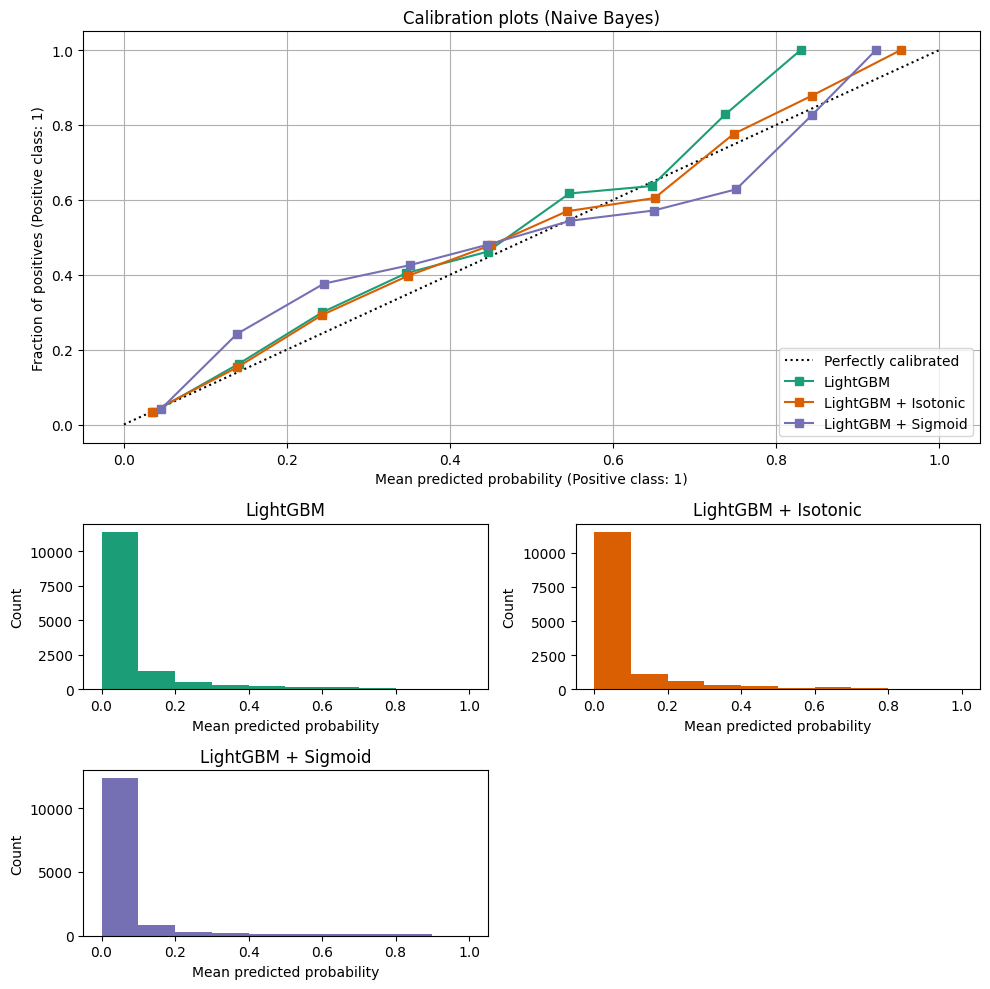

In [94]:
fig = plt.figure(figsize=(10, 10))
gs = GridSpec(4, 2)
colors = plt.get_cmap("Dark2")

ax_calibration_curve = fig.add_subplot(gs[:2, :2])
calibration_displays = {}
for i, (clf, name) in enumerate(lgbm_models):
    clf.fit(X_train, y_train)
    y_pred = clf.predict_proba(X_test)[:, 1]
    display = CalibrationDisplay.from_predictions(
        y_test,
        y_pred,
        n_bins=n_bins,
        name=name,
        ax=ax_calibration_curve,
        color=colors(i),
    )
    calibration_displays[name] = display

ax_calibration_curve.grid()
ax_calibration_curve.set_title("Calibration plots (Naive Bayes)")

# Add histogram
grid_positions = [(2, 0), (2, 1), (3, 0), (3, 1)]
for i, (_, name) in enumerate(lgbm_models):
    row, col = grid_positions[i]
    ax = fig.add_subplot(gs[row, col])

    ax.hist(
        calibration_displays[name].y_prob,
        range=(0, 1),
        bins=n_bins,
        label=name,
        color=colors(i),
    )
    ax.set(title=name, xlabel="Mean predicted probability", ylabel="Count")

plt.tight_layout()
plt.show()

In [95]:
from typing import Sequence, Tuple, Union

import numpy as np
from sklearn.calibration import calibration_curve


def expected_calibration_error(
    y_true: Union[np.ndarray, Sequence[int]],
    y_pred: Union[np.ndarray, Sequence[float]],
    n_bins: int = 10,
) -> Tuple[float, np.ndarray, np.ndarray]:
    """
    Calculates the Expected Calibration Error (ECE) for predicted probabilities.

    ECE is the weighted average of the absolute difference between the mean
    true outcome and the mean predicted probability in each confidence bin.
    The weights are the proportion of samples falling into each bin.

    Args:
        y_true: True binary labels (0 or 1).
        y_pred: Predicted probabilities for the positive class (between 0 and 1).
        n_bins: The number of bins to use for the calibration curve (default is 10).

    Returns:
        A tuple containing:
        - The calculated ECE (float).
        - The array of mean true probabilities per bin (prob_true).
        - The array of mean predicted probabilities per bin (prob_pred).
    """
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)
    N = len(y_true)

    # 1. Calculate the mean true probability and mean predicted probability for non-empty bins
    # prob_true and prob_pred only contain values for non-empty bins.
    prob_true, prob_pred = calibration_curve(y_true, y_pred, n_bins=n_bins)

    # 2. Determine the counts for the weights
    # The bins are uniform over [0, 1].
    bins = np.linspace(0.0, 1.0, n_bins + 1)

    # Calculate the count of samples that fall into each of the n_bins.
    # The range (0, 1) is used implicitly by calibration_curve.
    counts, _ = np.histogram(y_pred, bins=bins, range=(0.0, 1.0))

    # 3. Filter counts to match the non-empty bins returned by calibration_curve.
    # The only bins that contribute to ECE are those that are not empty (count > 0).
    non_empty_counts = counts[counts > 0]

    # 4. Calculate the weights (Ni / N)
    # The weight is the fraction of total samples in each non-empty bin.
    weights = non_empty_counts / N

    # 5. Calculate the ECE
    # ECE = sum_i (Weight_i * |prob_true_i - prob_pred_i|)
    ece = np.sum(weights * np.abs(prob_true - prob_pred))

    return ece, prob_true, prob_pred, weights

In [96]:
print(
    expected_calibration_error(
        y_test, lgbm_models[0][0].predict_proba(X_test)[:, 1], n_bins
    )
)
print(
    expected_calibration_error(
        y_test, lgbm_models[1][0].predict_proba(X_test)[:, 1], n_bins
    )
)
print(
    expected_calibration_error(
        y_test, lgbm_models[2][0].predict_proba(X_test)[:, 1], n_bins
    )
)

(np.float64(0.01021392930581221), array([0.03254957, 0.16198225, 0.29982363, 0.40432099, 0.46153846,
       0.61702128, 0.63679245, 0.82795699, 1.        ]), array([0.03591207, 0.14072683, 0.24343608, 0.34648521, 0.44594088,
       0.54642396, 0.64719969, 0.73748432, 0.83004538]), array([7.92794046e-01, 9.40390902e-02, 3.94379912e-02, 2.25359950e-02,
       1.62759964e-02, 1.30764415e-02, 1.47457745e-02, 6.46866523e-03,
       6.25999861e-04]))
(np.float64(0.006218562949350275), array([0.03376736, 0.15284974, 0.29307568, 0.39661017, 0.47931034,
       0.56944444, 0.60479042, 0.776     , 0.87804878, 1.        ]), array([0.03402552, 0.13919726, 0.24349085, 0.34794255, 0.45053559,
       0.54338337, 0.65087615, 0.74784172, 0.84381644, 0.95284574]), array([0.80127982, 0.08054532, 0.04319399, 0.02051888, 0.02017111,
       0.010016  , 0.01161578, 0.00869444, 0.00285178, 0.00111289]))
(np.float64(0.01569435747023984), array([0.04113796, 0.24201474, 0.37627119, 0.42541436, 0.47972973,
       

In [97]:
lgbm_cal_classifiers = lgbm_models[1][0].calibrated_classifiers_
print(type(lgbm_cal_classifiers[0]))
print(len(lgbm_cal_classifiers))
print([d for d in dir(lgbm_cal_classifiers[0]) if not d.startswith("__")])

<class 'sklearn.calibration._CalibratedClassifier'>
5
['calibrators', 'classes', 'estimator', 'method', 'predict_proba']


In [98]:
"""
Description                            Calculation                              Result
Expected Revenue per Year              $10,000 x 12.0% (Interest Rate)          $1,200
Expected Cost per Year                 $10,000 x 4.5% (Cost of Funds + OPEX)    $450
Expected Loss (EL)                     PD(5%) x LGD(70%) x EAD($10,000)         $350
Expected Net Value (Profit) per Year   $1,200 - $450 - $350                     $400
Profit Margin                          $400 / $10,000                           4.0%
"""

'\nDescription                            Calculation                              Result\nExpected Revenue per Year              $10,000 x 12.0% (Interest Rate)          $1,200\nExpected Cost per Year                 $10,000 x 4.5% (Cost of Funds + OPEX)    $450\nExpected Loss (EL)                     PD(5%) x LGD(70%) x EAD($10,000)         $350\nExpected Net Value (Profit) per Year   $1,200 - $450 - $350                     $400\nProfit Margin                          $400 / $10,000                           4.0%\n'

In [ ]:
def business_objective(y_true, y_pred, threshold, verbose=True) -> float:
    interest_rate = 0.12
    loan_status = y_true[y_pred < threshold]
    ead = 10000  # Exposure at Default
    total_approved_exposure = ead * len(loan_status)  # Total capital for normalization
    revenue = len(loan_status) * ead * interest_rate
    if verbose:
        print(f"revenue: {revenue}")
    cost_rate = 0.045  # Cost percentage of EAD for each approved loan
    cost = len(loan_status) * ead * cost_rate
    if verbose:
        print(f"cost: {cost}")
    lgd = 0.7  # Loss Given Default
    loss = np.sum(loan_status) * ead * lgd
    if verbose:
        print(f"loss: {loss}")
    profit = revenue - cost - loss
    if verbose:
        print(f"profit: {profit}")
    profit_per_exposure = (
        profit / total_approved_exposure
    )  # Normalize by total exposure
    if verbose:
        print(f"profit_per_exposure: {profit_per_exposure * 100:.2f}%")

    return profit, profit_per_exposure

In [100]:
y_true_dummy = np.array(
    [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
)
y_pred_dummy = np.array(
    [
        0.1,
        0.4,
        0.3,
        0.8,
        0.7,
        0.1,
        0.2,
        0.9,
        0.3,
        0.1,
        0.6,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.4,
        0.6,
        0.4,
        0.4,
        0.4,
        0.4,
    ]
)
print(len(y_true_dummy))
print(len(y_pred_dummy))
print(y_true_dummy[y_pred_dummy < 0.5])
print(len(y_true_dummy[y_pred_dummy < 0.5]))
print(business_objective(y_true_dummy, y_pred_dummy, threshold=0.5))

25
25
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1]
20
revenue: 24000.0
cost: 9000.0
loss: 7000.0
profit: 8000.0%
margin: 4.0%
(np.float64(8000.0), np.float64(4.0))


In [101]:
print(
    business_objective(
        y_test.values, lgbm_models[0][0].predict_proba(X_test)[:, 1], threshold=0.5
    )
)

revenue: 16650000.0
cost: 6243750.0
loss: 6993000.0
profit: 3413250.0%
margin: 2.46%
(np.float64(3413250.0), np.float64(2.46))


In [102]:
for t in np.arange(0.01, 1.0, 0.01):
    profit, margin = business_objective(
        y_test.values,
        lgbm_models[1][0].predict_proba(X_test)[:, 1],
        threshold=t,
        verbose=False,
    )
    print(f"Threshold: {t:.2f}, Profit: {profit:.0f}, Margin: {margin:.2f}%")

Threshold: 0.01, Profit: 674250, Margin: 6.86%
Threshold: 0.02, Profit: 2356250, Margin: 6.76%
Threshold: 0.03, Profit: 4161750, Margin: 6.51%
Threshold: 0.04, Profit: 5018750, Margin: 6.17%
Threshold: 0.05, Profit: 5362000, Margin: 5.98%
Threshold: 0.06, Profit: 5556500, Margin: 5.77%
Threshold: 0.07, Profit: 5767750, Margin: 5.61%
Threshold: 0.08, Profit: 5952250, Margin: 5.48%
Threshold: 0.09, Profit: 5922500, Margin: 5.23%
Threshold: 0.10, Profit: 5917000, Margin: 5.14%
Threshold: 0.11, Profit: 5876500, Margin: 5.00%
Threshold: 0.12, Profit: 5865000, Margin: 4.94%
Threshold: 0.13, Profit: 5811000, Margin: 4.83%
Threshold: 0.14, Profit: 5768000, Margin: 4.74%
Threshold: 0.15, Profit: 5729000, Margin: 4.66%
Threshold: 0.16, Profit: 5684000, Margin: 4.59%
Threshold: 0.17, Profit: 5693250, Margin: 4.57%
Threshold: 0.18, Profit: 5612250, Margin: 4.47%
Threshold: 0.19, Profit: 5594750, Margin: 4.43%
Threshold: 0.20, Profit: 5546500, Margin: 4.37%
Threshold: 0.21, Profit: 5501000, Margin:

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

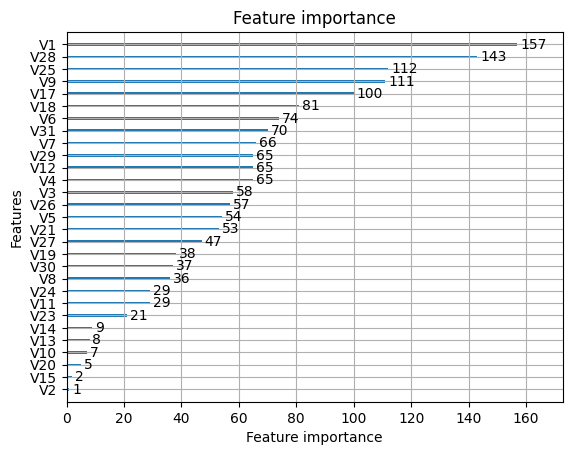

In [103]:
from lightgbm import plot_importance

plot_importance(lgbm_models[0][0])

In [104]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_proba_lgbm = np.mean(
    [m.predict_proba(X_test)[:, 1] for m in lgbm_cal_classifiers], axis=0
)

print(accuracy_score(y_test, np.rint(y_proba_lgbm)))
print(f1_score(y_test, np.rint(y_proba_lgbm)))
print(roc_auc_score(y_test, y_proba_lgbm))

0.9189677957849343
0.363039912520503
0.8598316651720713


In [105]:
def get_leaf_nodes(perp: PerpetualBooster):
    return [
        {node.num: node for node in tree_nodes if node.is_leaf}
        for tree_nodes in perp.get_node_lists()
    ]

In [106]:
def get_weights(leaf_nodes, pred_nodes):
    pred_weights = np.array(
        [
            [
                [
                    leaf_nodes[i][key].weights
                    for key in leaf_nodes[i].keys() & set(nodes)
                ][0]
                for nodes in tree_nodes
            ]
            for i, tree_nodes in enumerate(pred_nodes)
        ]
    )

    return np.sort(pred_weights, axis=2)

# Perpetual training

In [107]:
perp_models = []

for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    print(f"Fold {i}")
    X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
    y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
    perp = PerpetualBooster(budget=1.0, iteration_limit=10000)
    perp.fit(X_train_cv, y_train_cv)

    print(f"Number of trees: {perp.number_of_trees}")

    perp_models.append(perp)

Fold 0
Number of trees: 163
Fold 1
Number of trees: 142
Fold 2
Number of trees: 122
Fold 3
Number of trees: 131
Fold 4
Number of trees: 290


In [108]:
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score

y_proba_perp = np.mean([m.predict_proba(X_test)[:, 1] for m in perp_models], axis=0)

print(accuracy_score(y_test, np.rint(y_proba_perp)))
print(f1_score(y_test, np.rint(y_proba_perp)))
print(roc_auc_score(y_test, y_proba_perp))

0.9193851290255269
0.3564686285397002
0.8523821347413294


In [109]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))

In [110]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))
pred_lower = np.sum(np.min(pred_weights, axis=2), axis=0) + perp.base_score
pred_lower = 1.0 / (1.0 + np.exp(-pred_lower))
pred_lower.shape

(14377,)

In [111]:
pred_lower

array([0.01981131, 0.00444317, 0.03210161, ..., 0.01208054, 0.03987101,
       0.02342075], shape=(14377,))

In [112]:
pred_weights = get_weights(get_leaf_nodes(perp), perp.predict_nodes(X_test))
pred_upper = np.sum(np.max(pred_weights, axis=2), axis=0) + perp.base_score
pred_upper = 1.0 / (1.0 + np.exp(-pred_upper))
pred_upper.shape

(14377,)

In [113]:
pred_upper

array([0.04675169, 0.05982238, 0.09394607, ..., 0.0595104 , 0.17780166,
       0.05234123], shape=(14377,))

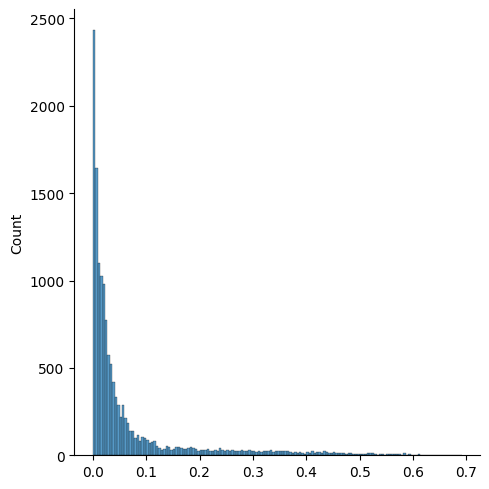

In [114]:
import seaborn as sns

sns.displot(pred_upper - pred_lower)

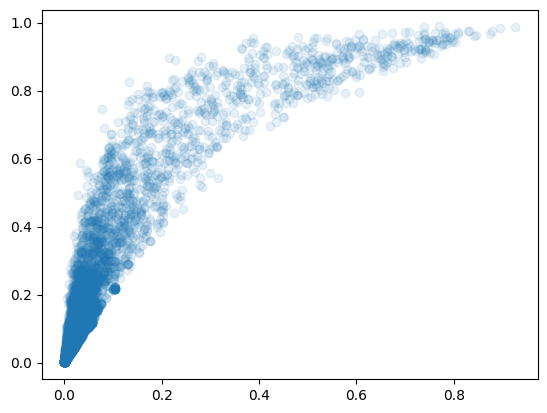

In [115]:
import matplotlib.pyplot as plt

plt.scatter(pred_lower, pred_upper, alpha=0.1)

In [116]:
max(pred_upper - pred_lower)

np.float64(0.691127302630661)

In [117]:
pred_weights.shape

(290, 14377, 5)

In [118]:
n_simulations = 100

In [119]:
indices = np.random.randint(
    low=0, high=5, size=(pred_weights.shape[0], pred_weights.shape[1], n_simulations)
)
new_pred_weights = np.take_along_axis(pred_weights, indices, axis=2)
print(f"New array shape: {new_pred_weights.shape}")

New array shape: (290, 14377, 100)


In [120]:
new_pred_weights_sum = np.sum(new_pred_weights, axis=0) + perp.base_score
new_pred_weights_sum.shape

(14377, 100)

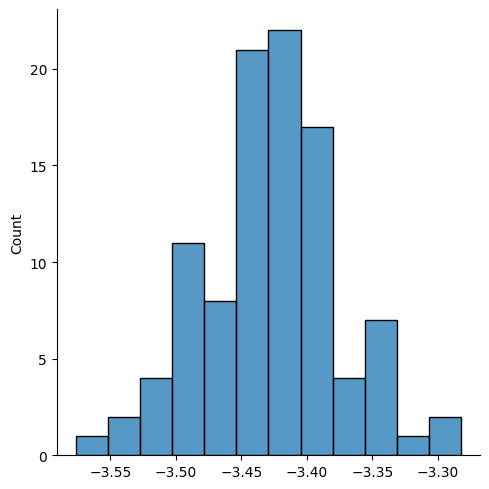

In [121]:
sns.displot(new_pred_weights_sum[0])

In [122]:
new_pred_weights_sum_proba = 1.0 / (1.0 + np.exp(-new_pred_weights_sum))
new_pred_weights_sum_proba.shape

(14377, 100)

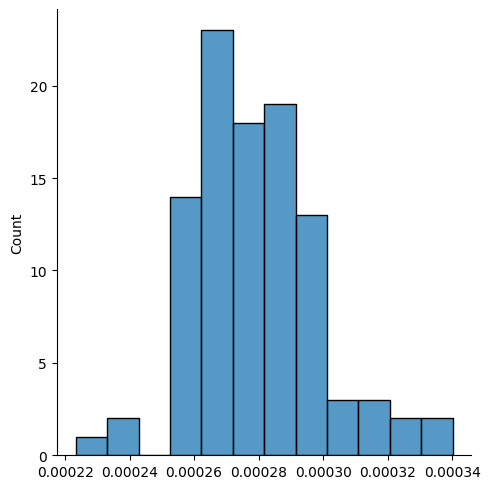

In [123]:
sns.displot(new_pred_weights_sum_proba[11000])

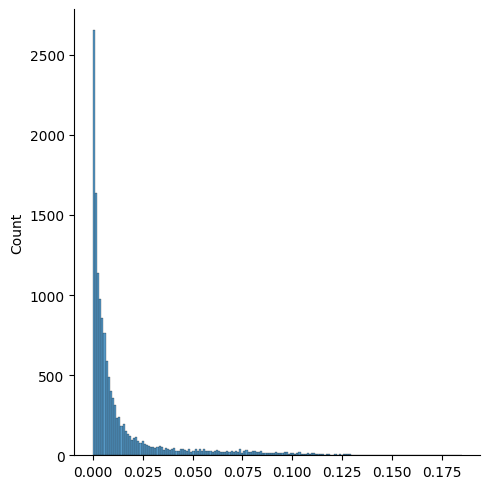

In [124]:
sns.displot(
    np.max(new_pred_weights_sum_proba, axis=1)
    - np.min(new_pred_weights_sum_proba, axis=1)
)

In [125]:
new_pred_weights_sum_proba.shape

(14377, 100)

In [126]:
def get_proba_sim(m_sim, X_sim, n_sim=100):
    pred_weights_sim = get_weights(get_leaf_nodes(m_sim), m_sim.predict_nodes(X_sim))
    indices_sim = np.random.randint(
        low=0,
        high=5,
        size=(pred_weights_sim.shape[0], pred_weights_sim.shape[1], n_sim),
    )
    new_pred_weights_sim = np.take_along_axis(pred_weights_sim, indices_sim, axis=2)
    new_pred_weights_sum_sim = np.sum(new_pred_weights_sim, axis=0) + m_sim.base_score
    new_pred_weights_sum_proba_sim = 1.0 / (1.0 + np.exp(-new_pred_weights_sum_sim))

    return new_pred_weights_sum_proba_sim

In [127]:
def objective_t(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)

    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        _X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        _y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_pred_sim = get_proba_sim(perp_models[i], X_test_cv, n_simulations)

        profits_fold = []
        for j in range(n_simulations):
            profit, margin = business_objective(
                y_test_cv.values, y_pred_sim[:, j], threshold=t, verbose=False
            )
            profits_fold.append(profit)

    profits.append(profits_fold)

    return np.mean(np.array(profits).flatten())

In [128]:
sampler_t = optuna.samplers.TPESampler(seed=seed)
study_t = optuna.create_study(direction="maximize", sampler=sampler_t)
study_t.optimize(objective_t, n_trials=10)

[I 2025-10-27 19:09:54,132] A new study created in memory with name: no-name-08cd1810-4932-4869-89ee-ef00dd99fc07
[I 2025-10-27 19:10:13,504] Trial 0 finished with value: 935820.0000000001 and parameters: {'threshold': 0.16464405117819741}. Best is trial 0 with value: 935820.0000000001.
[I 2025-10-27 19:10:31,605] Trial 1 finished with value: 899415.0 and parameters: {'threshold': 0.21455680991172585}. Best is trial 0 with value: 935820.0000000001.
[I 2025-10-27 19:10:48,856] Trial 2 finished with value: 927802.5 and parameters: {'threshold': 0.18082901282149316}. Best is trial 0 with value: 935820.0000000001.
[I 2025-10-27 19:11:06,153] Trial 3 finished with value: 936080.0000000001 and parameters: {'threshold': 0.16346495489906906}. Best is trial 3 with value: 936080.0000000001.
[I 2025-10-27 19:11:21,541] Trial 4 finished with value: 971872.5 and parameters: {'threshold': 0.1270964398016714}. Best is trial 4 with value: 971872.5.
[I 2025-10-27 19:11:38,701] Trial 5 finished with val

In [129]:
study_t.best_trial.params["threshold"]

0.1150324556477333

In [130]:
y_proba = np.mean([m.predict_proba(X_test)[:, 1] for m in perp_models], axis=0)
profit, margin = business_objective(
    y_test.values,
    y_proba,
    threshold=study_t.best_trial.params["threshold"],
    verbose=False,
)
print(f"Profit: {profit}, Margin: {margin}%")

Profit: 5755250.0, Margin: 4.710082658155332%


# Optimize threshold and weight index together

In [131]:
model_pred_weights = []
for i, (train, test) in enumerate(cv.split(X_train, y_train)):
    X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
    y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
    pred_weights = get_weights(
        get_leaf_nodes(perp_models[i]), perp_models[i].predict_nodes(X_test_cv)
    )
    model_pred_weights.append(pred_weights)

In [132]:
def get_proba_from_weights(p_weights, w, b_score):
    cal_weight, w_i_lower = math.modf(w)
    w_i_lower = int(w_i_lower)
    w_i_upper = w_i_lower + 1

    weights_lower = np.sum(p_weights[:, :, w_i_lower], axis=0) + b_score
    weights_upper = np.sum(p_weights[:, :, w_i_upper], axis=0) + b_score

    weighted = weights_lower * (1 - cal_weight) + weights_upper * cal_weight

    y_proba = 1.0 / (1.0 + np.exp(-weighted))

    return y_proba

In [133]:
def objective_w(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)
    w = trial.suggest_float("weight_index", 0.0, 4.0)

    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        _X_train_cv, _X_test_cv = X_train.iloc[train], X_train.iloc[test]
        _y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_proba = get_proba_from_weights(
            model_pred_weights[i], w, perp_models[i].base_score
        )

        profit, margin = business_objective(
            y_test_cv.values, y_proba, threshold=t, verbose=False
        )

    profits.append(profit)

    return np.mean(profits)

In [134]:
sampler_w = optuna.samplers.TPESampler(seed=seed)
study_w = optuna.create_study(direction="maximize", sampler=sampler_w)
study_w.optimize(objective_w, n_trials=1000)

[I 2025-10-27 19:12:48,537] A new study created in memory with name: no-name-0bf16743-2778-49f3-8f2a-42203cf320a1
[I 2025-10-27 19:12:48,583] Trial 0 finished with value: 964000.0000000001 and parameters: {'threshold': 0.16464405117819741, 'weight_index': 2.860757465489678}. Best is trial 0 with value: 964000.0000000001.
[I 2025-10-27 19:12:48,623] Trial 1 finished with value: 934750.0000000001 and parameters: {'threshold': 0.18082901282149316, 'weight_index': 2.1795327319875875}. Best is trial 0 with value: 964000.0000000001.
[I 2025-10-27 19:12:48,662] Trial 2 finished with value: 1002750.0 and parameters: {'threshold': 0.1270964398016714, 'weight_index': 2.5835764522666245}. Best is trial 2 with value: 1002750.0.
[I 2025-10-27 19:12:48,699] Trial 3 finished with value: 1020750.0 and parameters: {'threshold': 0.13127616337880774, 'weight_index': 3.567092003128319}. Best is trial 3 with value: 1020750.0.
[I 2025-10-27 19:12:48,739] Trial 4 finished with value: 795000.0 and parameters:

In [135]:
study_w.best_trial.params

{'threshold': 0.16429037587499723, 'weight_index': 3.9999658603860877}

In [136]:
y_proba = np.mean(
    [
        get_proba_from_weights(
            get_weights(get_leaf_nodes(m), m.predict_nodes(X_test)),
            study_w.best_trial.params["weight_index"],
            m.base_score,
        )
        for m in perp_models
    ],
    axis=0,
)
profit_w, margin_w = business_objective(
    y_test.values,
    y_proba,
    threshold=study_w.best_trial.params["threshold"],
    verbose=False,
)
print(f"Profit: {profit_w}, Margin: {margin_w}%")

Profit: 5863250.0, Margin: 4.886448870739228%


# Optimize business objective with calibrated LightGBM classifiers

In [137]:
best_threshold = 0
best_profit = 0

for t in np.arange(0.01, 0.2, 0.001):
    profits = []
    margins = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        m = lgbm_cal_classifiers[i]
        y_proba = m.predict_proba(X_test_cv)[:, 1]

        profit, margin = business_objective(
            y_test_cv.values, y_proba, threshold=t, verbose=False
        )
        profits.append(profit)
        margins.append(margin)

    if np.mean(profits) > best_profit:
        best_profit = np.mean(profits)
        best_threshold = t

    print(
        f"Threshold: {t:.3f}, Profit: {np.mean(profits):.0f}, Margin: {np.mean(margins):.2f}%"
    )

print(f"Best threshold: {best_threshold:.3f}, Best profit: {best_profit:.0f}")

Threshold: 0.010, Profit: 159400, Margin: 7.31%
Threshold: 0.011, Profit: 197350, Margin: 7.27%
Threshold: 0.012, Profit: 313550, Margin: 7.05%
Threshold: 0.013, Profit: 313550, Margin: 7.05%
Threshold: 0.014, Profit: 313550, Margin: 7.05%
Threshold: 0.015, Profit: 313550, Margin: 7.05%
Threshold: 0.016, Profit: 395250, Margin: 6.86%
Threshold: 0.017, Profit: 395250, Margin: 6.86%
Threshold: 0.018, Profit: 469150, Margin: 6.81%
Threshold: 0.019, Profit: 489550, Margin: 6.80%
Threshold: 0.020, Profit: 489550, Margin: 6.80%
Threshold: 0.021, Profit: 634400, Margin: 6.65%
Threshold: 0.022, Profit: 634400, Margin: 6.65%
Threshold: 0.023, Profit: 634400, Margin: 6.65%
Threshold: 0.024, Profit: 634400, Margin: 6.65%
Threshold: 0.025, Profit: 634400, Margin: 6.65%
Threshold: 0.026, Profit: 634400, Margin: 6.65%
Threshold: 0.027, Profit: 739350, Margin: 6.52%
Threshold: 0.028, Profit: 751500, Margin: 6.50%
Threshold: 0.029, Profit: 806150, Margin: 6.34%
Threshold: 0.030, Profit: 839000, Margin

In [138]:
y_proba = np.mean([m.predict_proba(X_test)[:, 1] for m in lgbm_cal_classifiers], axis=0)
profit_l, margin_l = business_objective(
    y_test.values, y_proba, threshold=best_threshold, verbose=False
)
print(f"Profit: {profit_l}, Margin: {margin_l}")

Profit: 5912750.0, Margin: 5.089739175346475


In [139]:
print(((profit_w - profit_l) / abs(profit_l)) * 100)

-0.8371739038518455


# Optimize threshold, weight index, budget together

In [140]:
budget_list = [0.1, 0.2, 0.3, 0.5, 1.0, 1.5, 2.0, 2.5]

In [141]:
p_models = []
model_pred_weights = []
for budget in budget_list:
    cv_pred_weights = []
    p_models_cv = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        X_train_cv, X_test_cv = X_train.iloc[train], X_train.iloc[test]
        y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]
        m = PerpetualBooster(budget=budget, iteration_limit=10000)
        m.fit(X_train_cv, y_train_cv)
        pred_weights = get_weights(get_leaf_nodes(m), m.predict_nodes(X_test_cv))
        cv_pred_weights.append(pred_weights)
        p_models_cv.append(m)
        print(f"Budget: {budget}, Fold: {i}, Number of trees: {m.number_of_trees}")
    print()
    p_models.append(p_models_cv)
    model_pred_weights.append(cv_pred_weights)

Budget: 0.1, Fold: 0, Number of trees: 198
Budget: 0.1, Fold: 1, Number of trees: 57
Budget: 0.1, Fold: 2, Number of trees: 154
Budget: 0.1, Fold: 3, Number of trees: 103
Budget: 0.1, Fold: 4, Number of trees: 119

Budget: 0.2, Fold: 0, Number of trees: 81
Budget: 0.2, Fold: 1, Number of trees: 80
Budget: 0.2, Fold: 2, Number of trees: 82
Budget: 0.2, Fold: 3, Number of trees: 71
Budget: 0.2, Fold: 4, Number of trees: 153

Budget: 0.3, Fold: 0, Number of trees: 124
Budget: 0.3, Fold: 1, Number of trees: 53
Budget: 0.3, Fold: 2, Number of trees: 108
Budget: 0.3, Fold: 3, Number of trees: 36
Budget: 0.3, Fold: 4, Number of trees: 203

Budget: 0.5, Fold: 0, Number of trees: 154
Budget: 0.5, Fold: 1, Number of trees: 84
Budget: 0.5, Fold: 2, Number of trees: 160
Budget: 0.5, Fold: 3, Number of trees: 54
Budget: 0.5, Fold: 4, Number of trees: 70

Budget: 1.0, Fold: 0, Number of trees: 163
Budget: 1.0, Fold: 1, Number of trees: 142
Budget: 1.0, Fold: 2, Number of trees: 122
Budget: 1.0, Fold

In [142]:
budget_index_min = 0
for i, b in enumerate(budget_list):
    if i == 0:
        continue
    cv_models_prev = p_models[i - 1]
    cv_models = p_models[i]
    min_diff_n_trees = min(
        [
            cv_models[j].number_of_trees - cv_models_prev[j].number_of_trees
            for j in range(len(cv_models))
        ]
    )
    if min_diff_n_trees < 0:
        budget_index_min = i
    print(
        f"i: {i}, budget: {b}, previous budget n_trees: {[cv_models_prev[j].number_of_trees for j in range(len(cv_models_prev))]}, current budget n_trees: {[cv_models[j].number_of_trees for j in range(len(cv_models))]}, min_diff_n_trees: {min_diff_n_trees}"
    )

print(f"Minimum budget index without tree count regression: {budget_index_min}")

i: 1, budget: 0.2, previous budget n_trees: [198, 57, 154, 103, 119], current budget n_trees: [81, 80, 82, 71, 153], min_diff_n_trees: -117
i: 2, budget: 0.3, previous budget n_trees: [81, 80, 82, 71, 153], current budget n_trees: [124, 53, 108, 36, 203], min_diff_n_trees: -35
i: 3, budget: 0.5, previous budget n_trees: [124, 53, 108, 36, 203], current budget n_trees: [154, 84, 160, 54, 70], min_diff_n_trees: -133
i: 4, budget: 1.0, previous budget n_trees: [154, 84, 160, 54, 70], current budget n_trees: [163, 142, 122, 131, 290], min_diff_n_trees: -38
i: 5, budget: 1.5, previous budget n_trees: [163, 142, 122, 131, 290], current budget n_trees: [371, 448, 237, 280, 521], min_diff_n_trees: 115
i: 6, budget: 2.0, previous budget n_trees: [371, 448, 237, 280, 521], current budget n_trees: [1064, 1110, 757, 710, 1689], min_diff_n_trees: 430
i: 7, budget: 2.5, previous budget n_trees: [1064, 1110, 757, 710, 1689], current budget n_trees: [3293, 2911, 1998, 2160, 4125], min_diff_n_trees: 12

In [ ]:
def objective_b(trial):
    t = trial.suggest_float("threshold", 0.0, 0.3)
    w = trial.suggest_float("weight_index", 0.0, 4.0)
    b = trial.suggest_int("budget_index", budget_index_min, len(budget_list) - 1)

    profits = []
    for i, (train, test) in enumerate(cv.split(X_train, y_train)):
        _X_train_cv, _X_test_cv = X_train.iloc[train], X_train.iloc[test]
        _y_train_cv, y_test_cv = y_train.iloc[train], y_train.iloc[test]

        y_proba = get_proba_from_weights(
            model_pred_weights[b][i], w, p_models[b][i].base_score
        )

        profit, margin = business_objective(
            y_test_cv.values, y_proba, threshold=t, verbose=False
        )

    profits.append(profit)

    return np.mean(profits)

In [151]:
sampler_b = optuna.samplers.TPESampler(seed=seed)
study_b = optuna.create_study(direction="maximize", sampler=sampler_b)
study_b.optimize(objective_b, n_trials=1000)

[I 2025-10-27 21:22:21,253] A new study created in memory with name: no-name-ceff566d-bed1-4c6e-839f-e21079150dc7
[I 2025-10-27 21:22:21,555] Trial 0 finished with value: 961750.0000000001 and parameters: {'threshold': 0.16464405117819741, 'weight_index': 2.860757465489678}. Best is trial 0 with value: 961750.0000000001.
[I 2025-10-27 21:22:21,778] Trial 1 finished with value: 937250.0000000001 and parameters: {'threshold': 0.18082901282149316, 'weight_index': 2.1795327319875875}. Best is trial 0 with value: 961750.0000000001.
[I 2025-10-27 21:22:22,006] Trial 2 finished with value: 987250.0 and parameters: {'threshold': 0.1270964398016714, 'weight_index': 2.5835764522666245}. Best is trial 2 with value: 987250.0.
[I 2025-10-27 21:22:22,259] Trial 3 finished with value: 1041250.0 and parameters: {'threshold': 0.13127616337880774, 'weight_index': 3.567092003128319}. Best is trial 3 with value: 1041250.0.
[I 2025-10-27 21:22:22,468] Trial 4 finished with value: 831500.0 and parameters: {

In [152]:
study_b.best_trial.params

{'threshold': 0.11956025036769574, 'weight_index': 3.850431846385094}

In [ ]:
y_proba = np.mean(
    [
        get_proba_from_weights(
            get_weights(get_leaf_nodes(m), m.predict_nodes(X_test)),
            study_b.best_trial.params["weight_index"],
            m.base_score,
        )
        for m in p_models[study_b.best_trial.params["budget_index"]]
    ],
    axis=0,
)
profit_b, margin_b = business_objective(
    y_test.values,
    y_proba,
    threshold=study_b.best_trial.params["threshold"],
    verbose=False,
)
print(f"Profit: {profit_b}, Margin: {margin_b}%")

Profit: 5988250.0, Margin: 5.180595207197855%


In [155]:
print(((profit_b - profit_l) / abs(profit_l)) * 100)

1.2769016109255422


In [156]:
# LightGBM n_estimators = 100
# 0.1 -> 1010250 -> -4.05428401259253
# 0.2 -> 989250  -> -2.7184548625882754
# 0.3 -> 987000  -> -8.580787883944526
# 0.5 -> 1135000 -> -4.479707308772228
# 1.0 -> 1046250 -> -0.22547434697524038
# 1.5 -> 1052000 -> 1.3060495192716752
# 2.0 -> 1073500 -> 1.9016421339232537
# 2.5 -> 1072500 -> -0.6041010805751723

In [157]:
# LightGBM n_estimators = 1000
# 2.0 -> 1074250 -> 1.131326776140825